<h1> Implementing Aroon Indicators using Python </h1>
<a href = "https://medium.com/@jasperc09/a-complete-guide-implementing-aroon-indicators-using-python-1fe79e4bede6"> Thank you for the Guide </a>

<b> The Aroon Indicator </b> uses two lines, one measures the up-trend whilst the other measures the down-trend. The Aroon Up line indicates bullish price changes and the Aroon Down line indicates bearish price changes. A crossover between these two lines can reveal a signal for trend changes showing entry or exit points e.g.

<li> If the Aroon Up crosses above the the Aroon Down, this indicates a potential uptrend. </li>
<li> If the Aroon Up crosses below the Aroon Down, this indicates a potential downtrend. </li>

In [1]:
#Import Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from yahoo_fin.stock_info import get_data

Ticker Symbol:  TSLA
Start Date (YYYY-MM-DD):  2010-01-01
End Date (YYYY-MM-DD):  2020-01-01
Time period (in days) 365


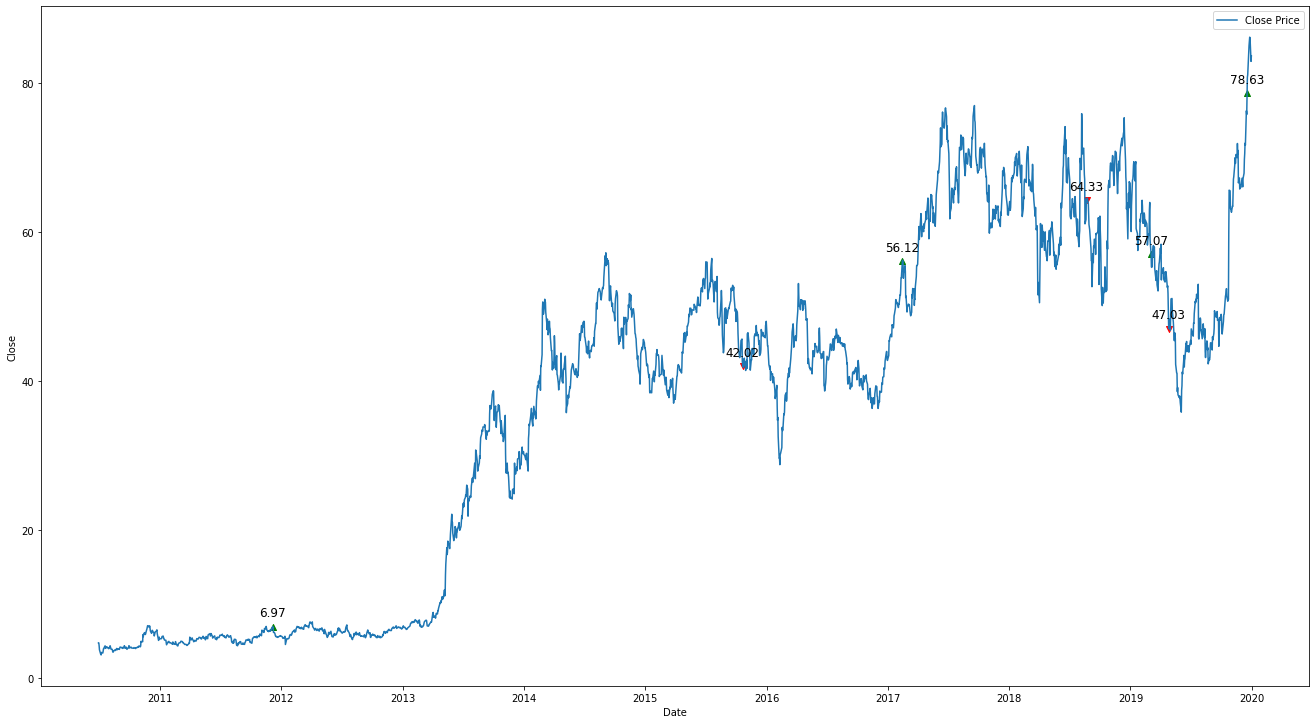

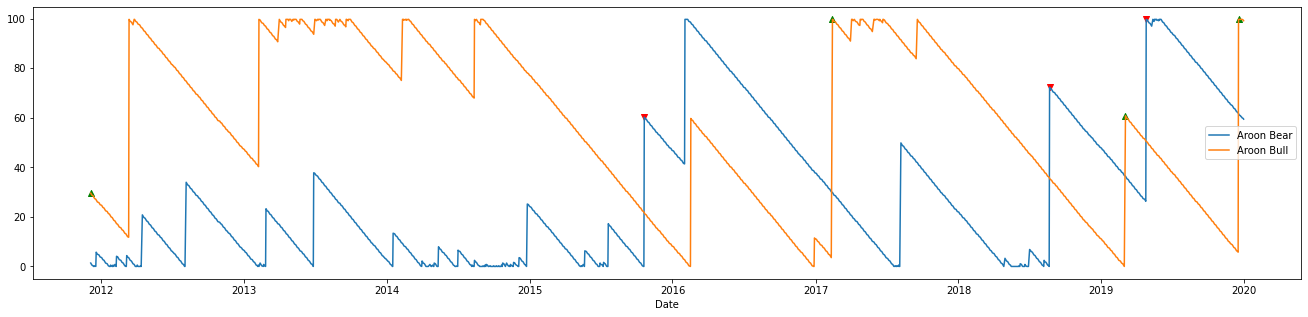

In [3]:
# Read data
# Rename and reformat pricing to 2 decimal places 
def read_data(tick_symbol, start_date, end_date):
    data = get_data(tick_symbol, start_date=start_date, 
                    end_date=end_date, index_as_date = False)
    data_new = data.rename(columns={'date':'Date', 'high':'High', 'low':'Low', 'close':'Close', 'adjclose':'Adj Close',   'volume':'Volume'})
    headers = ['High', 'Low', 'Close', 'Adj Close']
    for i in headers:
        data_new[i] = data_new[i].round(2)
    return data_new
#Recieves input data and number of periods (in days)
def aroon(data, day):
    #Declare for historical price subplot
    top_plot = plt.figure(figsize=(50,12.5)) 
    
    #Declare for Aroon subplot
    bottom_plot = plt.figure(figsize=(50,5))
    
    ax1 = top_plot.add_subplot(121)
    ax2 = bottom_plot.add_subplot(122)
    
    data['aroon_bull'] = 100 *  data['High'].rolling(day).apply(lambda x: x.argmax()) / (day)
    
    data['aroon_bear'] = 100 * data['Low'].rolling(day).apply(lambda x: x.argmin()) / (day)
    
    buy = [] #For buy signals
    sell = [] #For sell signals
    signals_buy = [] #Holds closing price relative to buy signal 
    signals_sell = [] #Holds closing price relative to sell signal
    flag = -1 #Tracks changes in signals
    
    #Loop through the length of the entire dataset 
    for i in range(len(data['Close'])):
        if data['aroon_bull'][i] > data['aroon_bear'][i]:
            if flag != 1: 
                buy.append(data['aroon_bull'][i])
                sell.append(np.nan)
                signals_buy.append(data['Close'][i])
                signals_sell.append(np.nan)
                flag = 1 #set flag to 1 indicating a bullish signal
            else: 
                #for succeeding bullish signals, disregard them 
                #until bearish signal arrives   
                buy.append(np.nan)
                sell.append(np.nan)
                signals_buy.append(np.nan)
                signals_sell.append(np.nan)
        elif data['aroon_bull'][i] < data['aroon_bear'][i]:
            if flag != 0:
                buy.append(np.nan)
                sell.append(data['aroon_bear'][i])
                signals_sell.append(data['Close'][i])
                signals_buy.append(np.nan)
                flag = 0 #set flag to 0 indicating bearish signal
            else:
                #for any succeeding bearish signals after flag = 0, 
                #disregard them until bullish signal arrives         
                buy.append(np.nan)
                sell.append(np.nan)
                signals_buy.append(np.nan)
                signals_sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
            signals_buy.append(np.nan)
            signals_sell.append(np.nan)
            
    data['buy_sig'] = buy #Assign signals and prices to new columns
    data['sell_sig'] = sell
    data['signals_price_buy'] = signals_buy
    data['signals_price_sell'] = signals_sell
    
    #Assign to their subplots 
    main_graph = sns.lineplot(data = data, x = 'Date', y = 'Close', label = 'Close Price', ax = ax1)
    aroon = sns.lineplot(data = data, x = 'Date', y = 'aroon_bear', label = 'Aroon Bear', ax = ax2)
    aroon = sns.lineplot(data = data, x = 'Date', y = 'aroon_bull', label = 'Aroon Bull', ax = ax2)
    aroon.set(ylabel='')
    
    #In the close price time-series, plot sell signals
    plot_combined = main_graph.scatter(data['Date'], data['signals_price_sell'], marker = 'v', color = 'red')
    
    #In the close price time-series, plot buy signals
    plot_combined = main_graph.scatter(data['Date'], data['signals_price_buy'], marker = '^', color = 'green')
    
    #Plot buy signals on Aroon plot
    plt.scatter(data['Date'], data['buy_sig'], label = 'Buy', marker = '^', color = 'green', alpha = 1)
    #Plot sell signals on Aroon plot
    plt.scatter(data['Date'], data['sell_sig'],label = 'Sell', marker = 'v', color = 'red', alpha = 1)
    
    #Assign and concatenate all buy and sell prices
    data_no_nan_buy = data.loc[data['signals_price_buy'].notnull()]
    data_no_nan_sell = data.loc[data['signals_price_sell'].notnull()]
    signs = pd.concat([data_no_nan_buy, data_no_nan_sell])
    signs = signs.reset_index(drop = True)
    
    #Label the corresponding signals to their prices in top plot
    for x,y,z in zip(signs['Date'], signs['Close'], signs['Close']):
        label = z #Label corresponds to labels in dataset
        main_graph.annotate(label, #text to be displayed
                     (x,y), #point for the specific label
                     textcoords="offset points", #text positioning
                     xytext=(0,10), #distance from text to points
                     ha='center',
                     fontsize = 12) #horizontal alignment
    #Return all plots
    plt.show()
    
if __name__ == "__main__":
    tick_symbol = input("Ticker Symbol: ")
    start_date = input("Start Date (YYYY-MM-DD): ")
    end_date = input("End Date (YYYY-MM-DD): ")
    
    #Define the read_data() function
    data = read_data(tick_symbol, start_date, end_date)
    
    #Define the number of periods 
    period = int(input("Time period (in days)"))
   
    #Define aroon function and input 
    aroon(data, period)